# Hurricane Season Forecasting
Objective: Predict the number of named storms that will occur in a given season based on prevailing conditions in May of that year (the time of year when many hurricane forecasts are released).

In [657]:
import pandas as pd
import numpy as np
from time import process_time, time
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import MultipleLocator

# sklearn model pipelining and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

# sklearn models
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.dummy import DummyRegressor

In [644]:
month_of_pred = 5 # 5 = May; 6 = June
train_test_year_split = 2010 # train will include this year; test will start the year after

In [645]:
# Read Number of Storms per year data from hurdat
# TS = Tropical Storms, HU = Hurricanes, TOTAL = total named storms
nstorms = pd.read_csv('data/nstorms_byyear.csv').drop(['Unnamed: 0'], axis=1)
nstorms.head()

,year,TS,HU,TOTAL
0,1950,3,11,14
1,1951,3,8,11
2,1952,2,5,7
3,1953,2,7,9
4,1954,3,6,9


In [646]:
buoy_data = pd.read_csv('data/monthly_buoydata.csv').drop(['Unnamed: 0'], axis=1).rename(columns={'YY':'year','MM':'month'})
buoy_data = buoy_data[['station_name','year','month','WDIR','WSPD','WVHT','PRES','ATMP','WTMP']]
buoy_data.head()

,station_name,year,month,WDIR,WSPD,WVHT,PRES,ATMP,WTMP
0,"Corpus Christi, TX",2023,1,147.584567,6.681963,1.498904,1017.714138,19.865897,20.871371
1,"Corpus Christi, TX",2023,2,170.765878,6.780516,1.511411,1021.014190,18.835244,20.997623
2,"Corpus Christi, TX",2023,3,119.578815,6.644980,1.560838,1014.904338,21.121627,21.373889
3,"Corpus Christi, TX",2023,4,112.603981,6.751396,1.506480,1015.142761,23.044101,23.354717
4,"Corpus Christi, TX",2023,5,124.815166,4.960036,0.889086,1014.877589,25.980540,26.215419


In [647]:
stations = buoy_data.station_name.unique()
# Stations with data going back to 1976:
stations_1976 = ['South Hatteras','Mid Gulf']

df_list = []

for station in stations_1976:
    print(station)
    df = buoy_data[buoy_data['station_name'] == station]
    first_year = np.max([np.min(df[['year']]), 1976])
    first_month_of_first_year = np.min(df[df['year'] == first_year]['month'])
    print(str(first_year) + '-' + str(first_month_of_first_year))
    
    # Create a date range from January 1975 OR first month for which data is avialable, to December 2023
    start_date = str(first_year)+'-'+str(first_month_of_first_year).zfill(2)
    date_range = pd.date_range(start=start_date, end='2023-12', freq='MS')
    # Create a dataframe from the date range
    full_date_df = pd.DataFrame({'date': date_range})
    # Extract year and month from the date
    full_date_df['year'] = full_date_df['date'].dt.year
    full_date_df['month'] = full_date_df['date'].dt.month
    # Drop the date column as it's no longer needed
    full_date_df.drop(columns='date', inplace=True)
    #print(full_date_df.head())
    
    merged_df = pd.merge(full_date_df, df, on=['year', 'month'], how='left')
    #print(merged_df[merged_df['year']==1978])
    merged_df = merged_df.ffill().bfill()
    #print(merged_df[merged_df['year']==1978])
    #print(merged_df.head(10))

    # Rename columns not named 'year' or 'month'
    station_nospace = station.replace(" ", "")+"_"
    df2 = merged_df.rename(columns=lambda x: f"{station_nospace}{x}" if x not in ['year', 'month', 'station_name'] else x, inplace=False)
    df2 = df2.drop(['station_name'], axis=1)

    df_list.append(df2)

buoy_data_wide = df_list[0]
# Iterate over the remaining DataFrames and merge them into the wide DataFrame
for df in df_list[1:]:
    buoy_data_wide = pd.merge(buoy_data_wide, df, on=['year', 'month'], how='outer')

buoy_data_may = buoy_data_wide[buoy_data_wide['month']==month_of_pred].reset_index(drop=True)
print(buoy_data_may.head())

South Hatteras
1976-1
Mid Gulf
1976-1
   year  month  SouthHatteras_WDIR  SouthHatteras_WSPD  SouthHatteras_WVHT  \
0  1976      5          174.836066            7.820902            1.344788   
1  1977      5          191.100402            5.914800            1.046774   
2  1978      5          182.210526            6.320974            1.259184   
3  1979      5          182.451923            6.328415            1.122034   
4  1980      5          190.704301            5.840726            1.271640   

   SouthHatteras_PRES  SouthHatteras_ATMP  SouthHatteras_WTMP  MidGulf_WDIR  \
0         1017.281070           21.195082           22.142798    126.619048   
1         1016.840000           21.525600           23.178313    145.346154   
2         1017.174157           21.523970           23.256180    137.108871   
3         1152.858992           21.932455           22.586250    130.362903   
4         1014.444489           22.034677           23.021909    138.636119   

   MidGulf_WSPD  M

In [648]:
# Ocean Nino Index Data

oni = pd.read_csv('data/Monthly_Nino_3.4_Index.csv')
# Note that we filter to the month of May here:
oni2 = oni[oni['month']==month_of_pred].drop(['Unnamed: 0','month','ONI_climAdjust','ONI_total'],axis=1).set_index('year')
oni2.head()

,ONI_anom
year,
1950,-1.37
1951,0.37
1952,0.23
1953,0.71
1954,-0.45


In [649]:
df = pd.merge(nstorms[nstorms['year']>= 1976], buoy_data_may, left_on = 'year', right_on = 'year', how = 'inner').set_index('year')
df = df.drop(['month'],axis=1)
df = pd.merge(df, oni2, left_on = 'year', right_on = 'year', how = 'left')
df.head()

,TS,HU,TOTAL,SouthHatteras_WDIR,SouthHatteras_WSPD,SouthHatteras_WVHT,SouthHatteras_PRES,SouthHatteras_ATMP,SouthHatteras_WTMP,MidGulf_WDIR,MidGulf_WSPD,MidGulf_WVHT,MidGulf_PRES,MidGulf_ATMP,MidGulf_WTMP,ONI_anom
year,,,,,,,,,,,,,,,,
1976,2,6,8,174.836066,7.820902,1.344788,1017.281070,21.195082,22.142798,126.619048,5.714488,0.889695,1043.881690,23.702120,25.060071,-0.31
1977,1,5,6,191.100402,5.914800,1.046774,1016.840000,21.525600,23.178313,145.346154,4.367308,1.204286,1015.015385,25.011538,25.721154,0.22
1978,6,5,11,182.210526,6.320974,1.259184,1017.174157,21.523970,23.256180,137.108871,4.766532,1.035593,1013.395181,25.568675,25.269697,-0.31
1979,3,5,8,182.451923,6.328415,1.122034,1152.858992,21.932455,22.586250,130.362903,6.003629,1.189069,1014.309677,25.319355,25.599588,0.19
1980,2,9,11,190.704301,5.840726,1.271640,1014.444489,22.034677,23.021909,138.636119,5.668414,0.920699,1012.922849,25.641667,25.988844,0.51


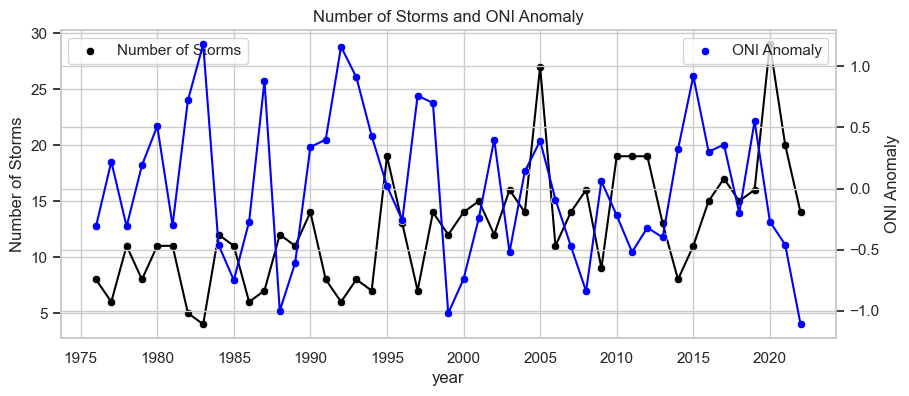

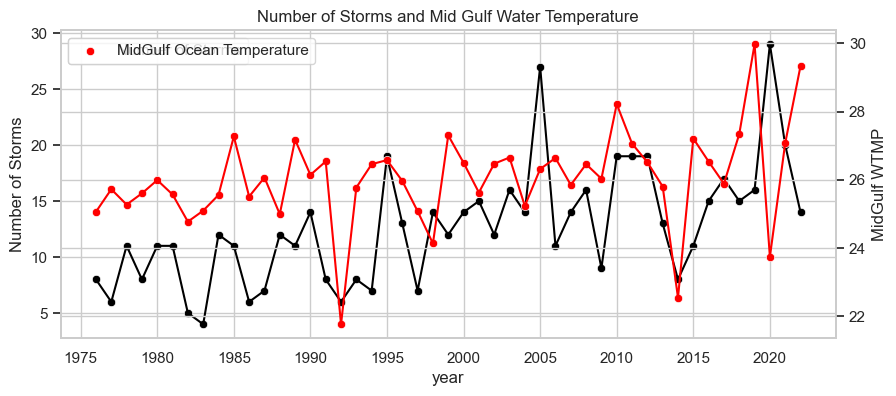

In [662]:
## Plotting the Key Features and Target Variable: ONI Anomaly
#fig, ax = plt.subplots(2, 1, figsize=(10, 8)) 
plt.figure(figsize=(10, 4))
sns.set(style = 'whitegrid')

# Plot the actual values
sns.scatterplot(data=df, x='year', y='TOTAL', color='black', label='Number of Storms')
sns.lineplot(data=df, x='year', y='TOTAL', color='black')
plt.ylabel('Number of Storms')

ax2 = plt.twinx()
sns.scatterplot(data = df, x='year', y='ONI_anom', color = 'blue', label = 'ONI Anomaly', ax = ax2)
sns.lineplot(data = df, x='year', y ='ONI_anom', color = 'blue', ax=ax2)
plt.ylabel('ONI Anomaly')

# Add labels and title
plt.xlabel('Year')
plt.title('Number of Storms and ONI Anomaly')
plt.legend()

# Customize the ticks and gridlines
plt.gca().xaxis.set_major_locator(MultipleLocator(5))  # Set the ticks every 5 years
plt.grid(True, which='both', axis='x')  # Ensure gridlines are visible

# Display the plot
plt.show()

## Now plot MidGulf Temperature:
#fig, ax = plt.subplots(2, 1, figsize=(10, 8)) 
plt.figure(figsize=(10, 4))
sns.set(style = 'whitegrid')

# Plot the actual values
sns.scatterplot(data=df, x='year', y='TOTAL', color='black', label='Number of Storms')
sns.lineplot(data=df, x='year', y='TOTAL', color='black')
plt.ylabel('Number of Storms')

ax2 = plt.twinx()
sns.scatterplot(data = df, x='year', y='MidGulf_WTMP', color = 'red', label = 'MidGulf Ocean Temperature', ax = ax2)
sns.lineplot(data = df, x='year', y ='MidGulf_WTMP', color = 'red', ax=ax2)
plt.ylabel('MidGulf WTMP')

# Add labels and title
plt.xlabel('Year')
plt.title('Number of Storms and Mid Gulf Water Temperature')
plt.legend()

# Customize the ticks and gridlines
plt.gca().xaxis.set_major_locator(MultipleLocator(5))  # Set the ticks every 5 years
plt.grid(True, which='both', axis='x')  # Ensure gridlines are visible

# Display the plot
plt.show()

In [563]:
## Define X and y from df:
unused_cols = ['TS','HU','ONI_anom']
df_nona = df.drop(unused_cols, axis=1).dropna()
X = df_nona.drop(['TOTAL'], axis=1)
y = df_nona['TOTAL']

#X.head()

## Initial Modeling, using default hyperparameters, training on ALL data

In [564]:
lr = LinearRegression().fit(X, y)
preds = lr.predict(X)

pipe_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso())
])
pipe_lasso.fit(X,y)
preds_lasso = pipe_lasso.predict(X)

pipe_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])
pipe_ridge.fit(X,y)
preds_ridge = pipe_ridge.predict(X)

In [565]:
y_preds = df_nona[['TOTAL']].copy().reset_index().rename(columns = {'TOTAL':'actual'})
baseline = np.mean(y_preds['actual'])
y_preds['baseline'] = baseline
y_preds['predicted'] = preds
y_preds['lasso'] = preds_lasso
y_preds['ridge'] = preds_ridge
y_preds.head()

,year,actual,baseline,predicted,lasso,ridge
0,1976,8,12.638298,9.368419,11.241810,9.469340
1,1977,6,12.638298,14.149519,12.703626,14.067325
2,1978,11,12.638298,13.206437,12.616781,13.151464
3,1979,8,12.638298,11.468885,12.656738,11.548657
4,1980,11,12.638298,11.331423,12.354792,11.403138


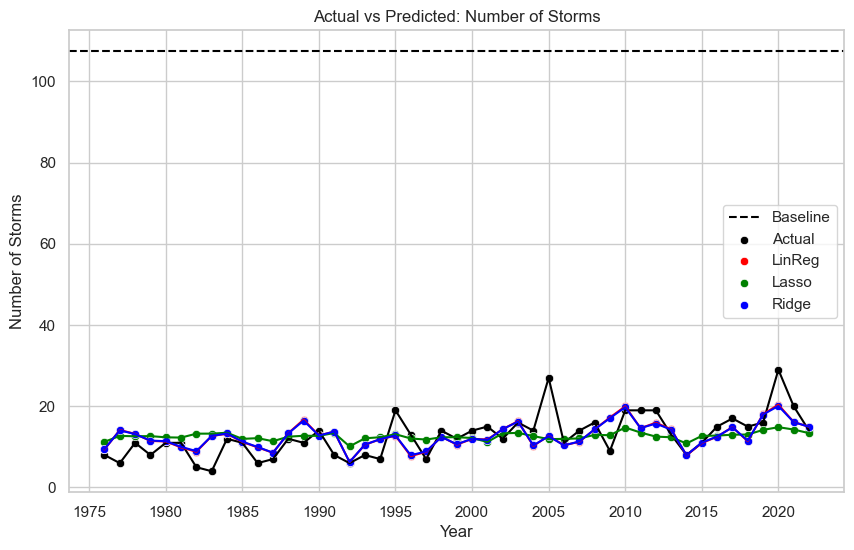

In [658]:
plt.figure(figsize=(10, 6))
plt.axhline(y=baseline, color='black', linestyle='--', label='Baseline')
sns.set(style = 'whitegrid')

# Plot the actual values
sns.scatterplot(data=y_preds, x='year', y='actual', color='black', label='Actual')
sns.lineplot(data=y_preds, x='year', y='actual', color='black')

# Plot the predicted values
sns.scatterplot(data=y_preds, x='year', y='predicted', color='red', label='LinReg')
sns.lineplot(data=y_preds, x='year', y='predicted', color='red')

# Plot the predicted values - Lasso
sns.scatterplot(data=y_preds, x='year', y='lasso', color='green', label='Lasso')
sns.lineplot(data=y_preds, x='year', y='lasso', color='green')

# Plot the predicted values - Ridge
sns.scatterplot(data=y_preds, x='year', y='ridge', color='blue', label='Ridge')
sns.lineplot(data=y_preds, x='year', y='ridge', color='blue')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Number of Storms')
plt.title('Actual vs Predicted: Number of Storms')
plt.legend()

# Customize the ticks and gridlines
plt.gca().xaxis.set_major_locator(MultipleLocator(5))  # Set the ticks every 5 years
plt.grid(True, which='both', axis='x')  # Ensure gridlines are visible

# Display the plot
plt.show()

Note: I expect that these (particularly the LinReg and barely-regularized Ridge analysis) are way overfit and would not do well on new data. This is a major challenge for this problem -- given the limited number of samples due to good data only going back 50 or so years, it may be difficult to create a predictive model that doesn't overfit.

#### Mean Squared Error

In [567]:
mse_baseline = mean_squared_error(y_preds['actual'],y_preds['baseline'])
print(mse_baseline)

27.08193752829335


In [568]:
mse_lr = mean_squared_error(y_preds['actual'],y_preds['predicted'])
print(mse_lr)

17.771080947971818


In [569]:
mse_lasso = mean_squared_error(y_preds['actual'],y_preds['lasso'])
print(mse_lasso)

23.465946307491883


# Same models with GridSearchCV and a Test/Train split:
- Train Test split with data before 2009 as train data, 2009 on used as test data
- Scaling with StandardScaler()
- Grid search for best hyperparameters for Lasso and Ridge (alpha term that controls amount of regularization)

Introduce a new "y" to train on: *Accumulated Cyclone Energy (ACE)*, which accounts for storm duration and strength (stronger, longer duration storms count more toward ACE). In some ways ACE is a better measure of hurricane activity, and perhaps it will be easier to predict than the simple storm count.

In [629]:
ace0 = pd.read_csv('data/ace-north-atlantic-hurricanes.csv')
ace = ace0[['Year','Acumulated cyclone energy index']].rename(columns={'Acumulated cyclone energy index':'ACE','Year':'year'}).set_index('year')
y_wACE = pd.merge(y, ace, on='year')
y_wACE = y_wACE.rename(columns={'TOTAL':'NumStorms'})

In [571]:
X_train = X[X.index <= train_test_year_split]
X_test = X[X.index > train_test_year_split]
y_df_train = y_wACE[y_wACE.index <= train_test_year_split]
y_df_test = y_wACE[y_wACE.index > train_test_year_split]

# BEFORE TRAINING YOU NEED TO SPECIFY which column to train on; NumStorms or ACE
# See arg ACE = True/False in run_grid function
print(y_df_train.head())

      NumStorms  ACE
year                
1976          8   84
1977          6   25
1978         11   63
1979          8   93
1980         11  149


In [617]:
def run_grid(model_setup, ACE = False, N_JOBS = 1, N_CV = 5):
    if ACE:
        y_train = y_df_train['ACE']
        y_test = y_df_test['ACE']
    else:
        y_train = y_df_train['NumStorms']
        y_test = y_df_test['NumStorms']

    start_time = time()
    
    # Make Pipeline
    pipe = Pipeline([
        #('preprocessor',preprocessor),
        ('poly', PolynomialFeatures(degree = 3)),
        ('scaler',StandardScaler()),
        (model_setup.get('name'), model_setup.get('model'))
        ])

    # Fit Grid on all params
    grid = GridSearchCV(estimator = pipe,
                        param_grid = model_setup.get('param_dict'),
                       cv = N_CV,
                       n_jobs = N_JOBS)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_train_preds = best_model.predict(X_train)
    y_test_preds = best_model.predict(X_test)

    # Save stuff to a dataframe (best params, fit time, scores)
    res_dict = {'model': [model_setup.get('name')],
                'best_params': [grid.best_params_],
                'best_score': [grid.best_score_],
                'fit time': [grid.refit_time_],
               'train r2': [grid.score(X_train, y_train)],
               'test r2': [grid.score(X_test, y_test)],
                'train mse': [mean_squared_error(y_train, y_train_preds)],
                'test mse': [mean_squared_error(y_test, y_test_preds)]
               }
    res_df = pd.DataFrame(res_dict)

    feature_names = best_model.named_steps['poly'].get_feature_names_out()
    if model_setup.get('name') != 'dummy':
        coefs = best_model.named_steps[model_setup.get('name')].coef_
        coef_df = pd.DataFrame({'feature':feature_names, 'coef':coefs})
    else:
        coef_df = pd.DataFrame()

    end_time = time()
    print(f"Elapsed time: {end_time - start_time} seconds")
    
    return(res_df, best_model, coef_df)

In [573]:
model_setup_linreg = {
    'name':'linreg',
    'param_dict':{'poly__degree':[1,2,3,4,5,6]},
    'model': LinearRegression()
}
results_linreg, best_linreg, _ = run_grid(model_setup_linreg, N_JOBS = 2)
results_linreg

Elapsed time: 0.9098701477050781 seconds


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,linreg,{'poly__degree': 1},-7.65602,0.001936,0.268751,-1.192187,15.589625,56.022554


In [574]:
# Training Basic Linear Regression on ACE:
results_linreg_ACE, best_linreg_ACE, _ = run_grid(model_setup_linreg, ACE = True, N_JOBS = 2)
results_linreg_ACE

Elapsed time: 0.18466711044311523 seconds


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,linreg,{'poly__degree': 1},-4.139753,0.002981,0.205142,-2.16202,3102.767792,7751.605075


In [575]:
model_setup_lasso = {
    'name':'lasso',
    'param_dict':{'poly__degree':[1,2,3,4,6],
                  'lasso__alpha':[1],
                  'lasso__max_iter':[1000000],
                  'lasso__random_state':[42,43]},
    'model': Lasso()
}
results_lasso, best_lasso, coefs_lasso = run_grid(model_setup_lasso, N_JOBS = 2)
results_lasso

Elapsed time: 0.6364870071411133 seconds


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,lasso,"{'lasso__alpha': 1, 'lasso__max_iter': 1000000...",-0.766831,0.002389,0.118166,-0.898298,18.799987,48.512049


In [576]:
# Training Lasso on ACE:
model_setup_lasso = {
    'name':'lasso',
    'param_dict':{'poly__degree':[1,2,3,4,5],
                  'lasso__alpha':[1],
                  'lasso__max_iter':[750000],
                  'lasso__random_state':[42,43]},
    'model': Lasso()
}
results_lasso_ACE, best_lasso_ACE, _ = run_grid(model_setup_lasso, ACE = True, N_JOBS = 2)
results_lasso_ACE

Elapsed time: 2.5718190670013428 seconds


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,lasso,"{'lasso__alpha': 1, 'lasso__max_iter': 750000,...",-2.425505,0.002461,0.189373,-1.156563,3164.323157,5286.755364


In [577]:
model_setup_ridge = {
    'name':'ridge',
    'param_dict':{'poly__degree':[1,2,3,4,5,6],
                  'ridge__random_state':[42,43],
                  'ridge__alpha':[0.0001,0.001,0.01,0.1,1,10]},
    'model': Ridge()
}
results_ridge, best_ridge, coefs_ridge = run_grid(model_setup_ridge, N_JOBS = 2)
results_ridge

Elapsed time: 0.721757173538208 seconds


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,ridge,"{'poly__degree': 1, 'ridge__alpha': 10, 'ridge...",-1.343024,0.001024,0.23675,-0.804511,16.271874,46.11527


In [578]:
# Training Ridge Regression Model on ACE:
results_ridge_ACE, best_ridge_ACE, _ = run_grid(model_setup_ridge, ACE = True, N_JOBS = 2)
results_ridge_ACE

Elapsed time: 0.64286208152771 seconds


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,ridge,"{'poly__degree': 1, 'ridge__alpha': 10, 'ridge...",-0.86343,0.002073,0.141857,-0.387124,3349.802356,3400.494834


In [618]:
model_setup_dummy = {
    'name':'dummy',
    'param_dict':{'poly__degree':[1],
                  'dummy__strategy':['mean']},
    'model':DummyRegressor()
}
results_dummy, best_dummy, coefs_dummy = run_grid(model_setup_dummy, N_JOBS = 2)
results_dummy

Elapsed time: 0.030832290649414062 seconds


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,dummy,"{'dummy__strategy': 'mean', 'poly__degree': 1}",-0.940412,0.0013,0.0,-0.963411,21.319184,50.176054


In [620]:
results_dummy_ACE, best_dummy_ACE, coefs_dummy_ACE = run_grid(model_setup_dummy, ACE = True, N_JOBS = 2)
results_dummy_ACE

Elapsed time: 0.0307009220123291 seconds


,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,dummy,"{'dummy__strategy': 'mean', 'poly__degree': 1}",-0.466993,0.002658,0.0,-0.159843,3903.547755,2843.323673


In [579]:
# Ignore these warnings from seaborn:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

   year  actual  ACE   baseline     linreg      lasso      ridge
0  1976       8   84  12.638298  11.668444  10.712887  10.654446
1  1977       6   25  12.638298  11.303921  11.252874  11.318573
2  1978      11   63  12.638298  10.203372  10.884114  10.750118
3  1979       8   93  12.638298  11.272425  11.153577  11.144056
4  1980      11  149  12.638298  11.799950  11.471529  11.456147


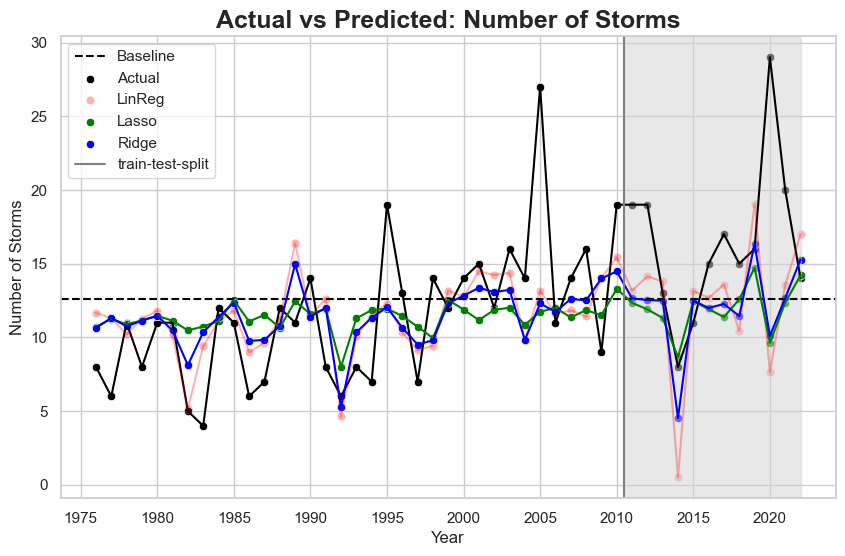

In [580]:
preds_linreg = best_linreg.predict(X)
preds_ridge = best_ridge.predict(X)
preds_lasso = best_lasso.predict(X)

y_preds_gridsearch = pd.DataFrame(y_wACE).rename(columns={'NumStorms':'actual'})
baseline = np.mean(y_preds_gridsearch['actual'])
y_preds_gridsearch['baseline'] = baseline
y_preds_gridsearch['linreg'] = preds_linreg
y_preds_gridsearch['lasso'] = preds_lasso
y_preds_gridsearch['ridge'] = preds_ridge
y_preds_gridsearch.reset_index(inplace=True)
y_preds_gridsearch = y_preds_gridsearch.clip(lower=0)
print(y_preds_gridsearch.head())

plt.figure(figsize=(10, 6))
plt.axhline(y=baseline, color='black', linestyle='--', label='Baseline')
sns.set(style = 'whitegrid')

# Plot the actual values
sns.scatterplot(data=y_preds_gridsearch, x='year', y='actual', color='black', label='Actual')
sns.lineplot(data=y_preds_gridsearch, x='year', y='actual', color='black')

# Plot the predicted values
sns.scatterplot(data=y_preds_gridsearch, x='year', y='linreg', color='red', label='LinReg', alpha = 0.3)
sns.lineplot(data=y_preds_gridsearch, x='year', y='linreg', color='red', alpha = 0.3)

# Plot the predicted values - Lasso
sns.scatterplot(data=y_preds_gridsearch, x='year', y='lasso', color='green', label='Lasso')
sns.lineplot(data=y_preds_gridsearch, x='year', y='lasso', color='green')

# Plot the predicted values - Ridge
sns.scatterplot(data=y_preds_gridsearch, x='year', y='ridge', color='blue', label='Ridge')
sns.lineplot(data=y_preds_gridsearch, x='year', y='ridge', color='blue')

plt.axvline(x=train_test_year_split+0.5, color='gray', linestyle='-', label='train-test-split')
plt.axvspan(train_test_year_split+0.5, np.max(y_preds_gridsearch['year'].astype(int)), color='lightgray', alpha=0.5)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Number of Storms')
plt.title('Actual vs Predicted: Number of Storms', weight = 'bold', size = 18)
plt.legend()

# Customize the ticks and gridlines
plt.gca().xaxis.set_major_locator(MultipleLocator(5))  # Set the ticks every 5 years
plt.grid(True, which='both', axis='x')  # Ensure gridlines are visible

# Display the plot
plt.show()

   year  actual    baseline      linreg       lasso       ridge
0  1976      84  107.425532  133.967107  121.127929  105.733753
1  1977      25  107.425532   88.323803   94.345440   97.162836
2  1978      63  107.425532   82.998714   90.923454   94.781580
3  1979      93  107.425532  122.167632  118.278043  108.895576
4  1980     149  107.425532  133.838066  122.482929  114.828914


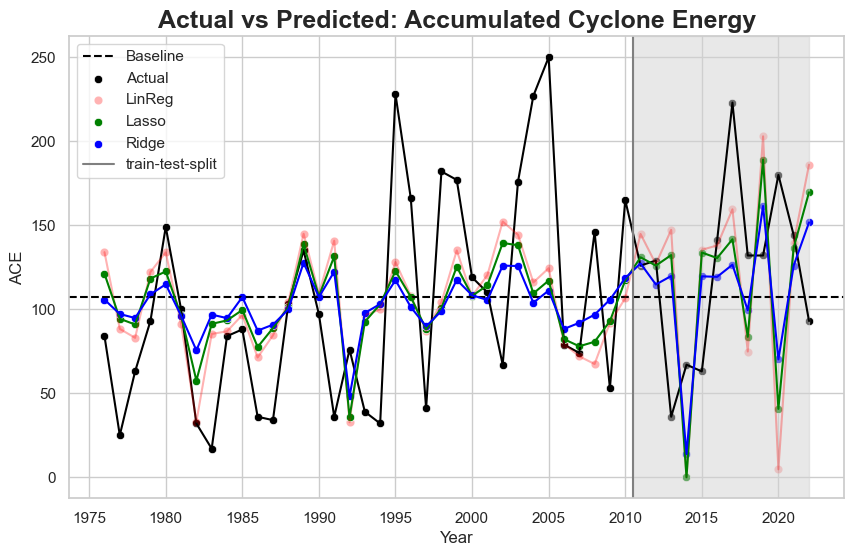

In [581]:
preds_linreg = best_linreg_ACE.predict(X)
preds_ridge = best_ridge_ACE.predict(X)
preds_lasso = best_lasso_ACE.predict(X)

y_preds_gridsearch_ACE = y_wACE[['ACE']].rename(columns={'ACE':'actual'})
baseline = np.mean(y_preds_gridsearch_ACE['actual'])
y_preds_gridsearch_ACE['baseline'] = baseline
y_preds_gridsearch_ACE['linreg'] = preds_linreg
y_preds_gridsearch_ACE['lasso'] = preds_lasso
y_preds_gridsearch_ACE['ridge'] = preds_ridge
y_preds_gridsearch_ACE.reset_index(inplace=True)
y_preds_gridsearch_ACE = y_preds_gridsearch_ACE.clip(lower=0)
print(y_preds_gridsearch_ACE.head())

plt.figure(figsize=(10, 6))
plt.axhline(y=baseline, color='black', linestyle='--', label='Baseline')
sns.set(style='whitegrid')

# Plot the actual values
sns.scatterplot(data=y_preds_gridsearch_ACE, x='year', y='actual', color='black', label='Actual')
sns.lineplot(data=y_preds_gridsearch_ACE, x='year', y='actual', color='black')

# Plot the predicted values - Linear Regression with no Regularization
sns.scatterplot(data=y_preds_gridsearch_ACE, x='year', y='linreg', color='red', label='LinReg', alpha = 0.3)
sns.lineplot(data=y_preds_gridsearch_ACE, x='year', y='linreg', color='red',alpha = 0.3)

# Plot the predicted values - Lasso
sns.scatterplot(data=y_preds_gridsearch_ACE, x='year', y='lasso', color='green', label='Lasso')
sns.lineplot(data=y_preds_gridsearch_ACE, x='year', y='lasso', color='green')

# Plot the predicted values - Ridge
sns.scatterplot(data=y_preds_gridsearch_ACE, x='year', y='ridge', color='blue', label='Ridge')
sns.lineplot(data=y_preds_gridsearch_ACE, x='year', y='ridge', color='blue')

plt.axvline(x=train_test_year_split+0.5, color='gray', linestyle='-', label='train-test-split')
plt.axvspan(train_test_year_split+0.5, np.max(y_preds_gridsearch_ACE['year'].astype(int)), color='lightgray', alpha=0.5)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('ACE')
plt.title('Actual vs Predicted: Accumulated Cyclone Energy', weight = 'bold', size = 18)
plt.legend()

# Customize the ticks and gridlines
from matplotlib.ticker import MultipleLocator
plt.gca().xaxis.set_major_locator(MultipleLocator(5))  # Set the ticks every 5 years
plt.grid(True, which='both', axis='x')  # Ensure gridlines are visible

# Display the plot
plt.show()

# Discussion of Results
Take a look at the test r2 for lasso and ridge regression above. We have no confidence that this model is working correctly (r^2 < 0!!).

Because of this outcome, I've decided to do a different type of forecast: using monthly atmospheric/climatological data to forecast number of storms in that month. This effectively 12x the available data since we can use monthly rather than only May data.

### Were the models better at predicting Number of Storms or ACE?

Hypothesis: The models will be better at predicting Accumulated Cyclone Energy (ACE) than Number of Storms. In other words, I am hypothesizing that the data we are using (El Nino index and sea surface temperature data) will better predict the overall strength and duration of storms in a season (since sea surface temperatures are known to drive and sustain hurricanes) than number of storms (which is a smaller, more discrete, perhaps more random number to predict, and influenced by many factors beyond sea surface temperatures.

In [623]:
results_nstorms = pd.concat([results_linreg, results_lasso, results_ridge, results_dummy], ignore_index = True)
results_nstorms.insert(0, 'target_var', 'NumStorms')
results_ACE = pd.concat([results_linreg_ACE, results_lasso_ACE, results_ridge_ACE, results_dummy_ACE], ignore_index = True)
results_ACE.insert(0, 'target_var', 'ACE')
results_all = pd.concat([results_nstorms, results_ACE], ignore_index = True)
results_all

,target_var,model,best_params,best_score,fit time,train r2,test r2,train mse,test mse
0,NumStorms,linreg,{'poly__degree': 1},-7.656020,0.001936,0.268751,-1.192187,15.589625,56.022554
1,NumStorms,lasso,"{'lasso__alpha': 1, 'lasso__max_iter': 1000000...",-0.766831,0.002389,0.118166,-0.898298,18.799987,48.512049
2,NumStorms,ridge,"{'poly__degree': 1, 'ridge__alpha': 10, 'ridge...",-1.343024,0.001024,0.236750,-0.804511,16.271874,46.115270
3,NumStorms,dummy,"{'dummy__strategy': 'mean', 'poly__degree': 1}",-0.940412,0.001300,0.000000,-0.963411,21.319184,50.176054
4,ACE,linreg,{'poly__degree': 1},-4.139753,0.002981,0.205142,-2.162020,3102.767792,7751.605075
5,ACE,lasso,"{'lasso__alpha': 1, 'lasso__max_iter': 750000,...",-2.425505,0.002461,0.189373,-1.156563,3164.323157,5286.755364
6,ACE,ridge,"{'poly__degree': 1, 'ridge__alpha': 10, 'ridge...",-0.863430,0.002073,0.141857,-0.387124,3349.802356,3400.494834
7,ACE,dummy,"{'dummy__strategy': 'mean', 'poly__degree': 1}",-0.466993,0.002658,0.000000,-0.159843,3903.547755,2843.323673


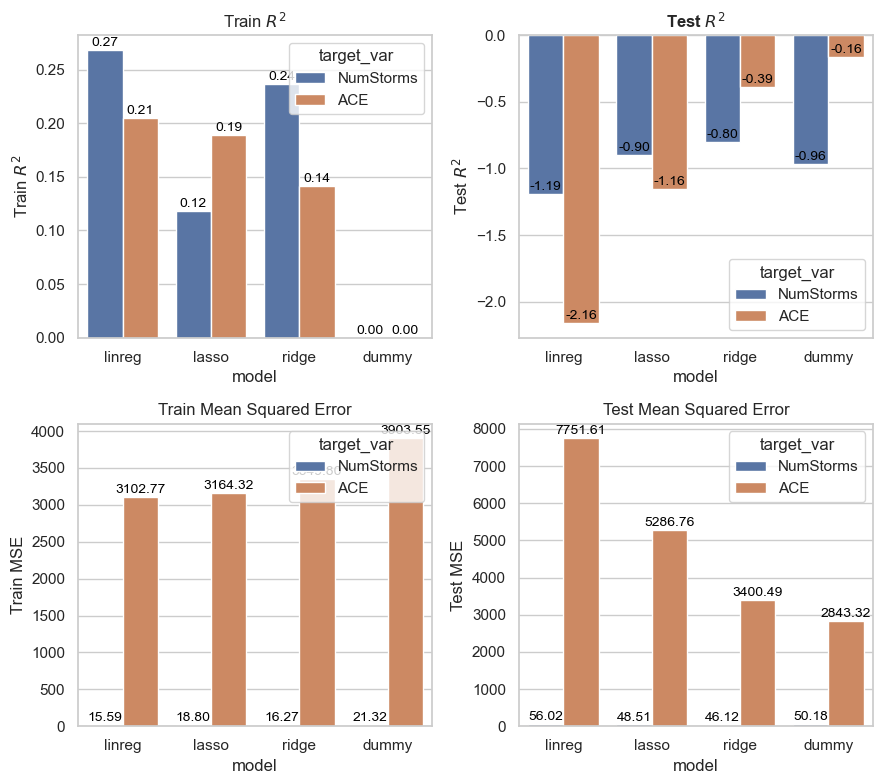

In [624]:
fig, ax = plt.subplots(2, 2, figsize=(9, 8)) 

# Function to add annotations
def add_annotations(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Train R2
sns.barplot(x='model', y='train r2', hue = 'target_var', data=results_all, ax=ax[0,0])
ax[0,0].set_title('Train $R^2$')
ax[0,0].set_ylabel('Train $R^2$')
add_annotations(ax[0,0])
#fig.gca().get_legend().set_title(None)
#ax[0,0].legend(bbox_to_anchor=(1.02, 0.15), loc='upper left', borderaxespad=0)

# Test R2
sns.barplot(x='model', y='test r2', hue = 'target_var', data=results_all, ax=ax[0,1])
ax[0,1].set_title('Test $R^2$', weight = 'bold')
ax[0,1].set_ylabel('Test $R^2$')
add_annotations(ax[0,1])

# Train MSE
sns.barplot(x='model', y='train mse', hue = 'target_var', data=results_all, ax=ax[1,0])
ax[1,0].set_title('Train Mean Squared Error')
ax[1,0].set_ylabel('Train MSE')
add_annotations(ax[1,0])

# Test MSE
sns.barplot(x='model', y='test mse', hue = 'target_var', data=results_all, ax=ax[1,1])
ax[1,1].set_title('Test Mean Squared Error')
ax[1,1].set_ylabel('Test MSE')
add_annotations(ax[1,1])

plt.tight_layout()
plt.show()

Probably the most important statistic above is the negative test R^2, which could reveal one or more of the following issues:
- Not enough samples of data
- Data quality issues
- Not capturing the important features for hurricane prediction; or other inadequate feature engineering
- Over or underfitting
- Significant differences in behavior between the training and test data

### Inspecting Two Years where the Modeling Did and Did NOT predict well: 2014, 2020

What is happening in these years? Lets look at the ACE per Storm. Hypothesis is that the model is able to capture ACE per storm since this will be driven more directly by ocean temperatures (warm waters drive storm growth, but can't necessarily create a storm without other meteorological factors).

2020: Many storms, but water temperatures were not abnormally high heading into that season. ACE per storm was lower than average -- see below plot.

      NumStorms  ACE  ACE_per_storm
year                               
1976          8   84      10.500000
1977          6   25       4.166667
1978         11   63       5.727273
1979          8   93      11.625000
1980         11  149      13.545455


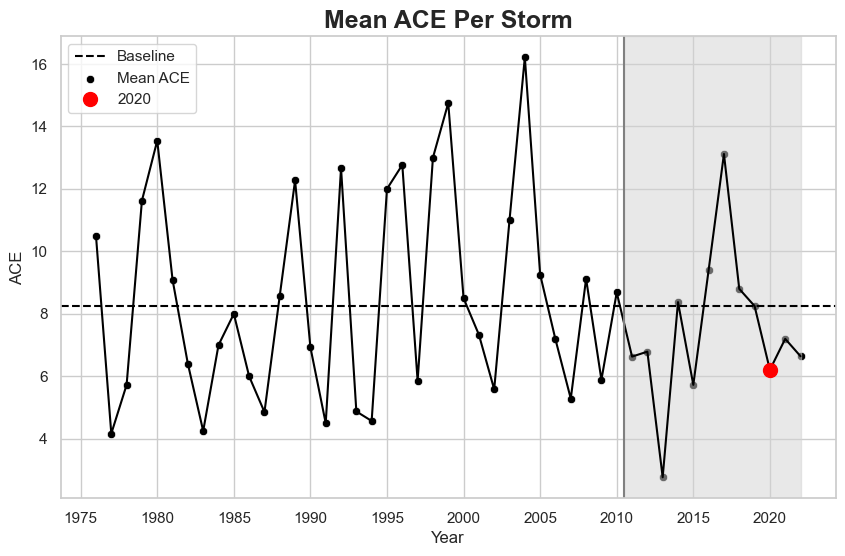

In [668]:
y_wACE['ACE_per_storm'] = y_wACE['ACE']/y_wACE['NumStorms']
avg_ace_per_storm = np.mean(y_wACE['ACE_per_storm'])
print(y_wACE.head())

plt.figure(figsize=(10, 6))
plt.axhline(y=avg_ace_per_storm, color='black', linestyle='--', label='Baseline')
sns.set(style='whitegrid')

# Plot Mean ACE per Storm
sns.scatterplot(data=y_wACE, x='year', y='ACE_per_storm', color='black', label='Mean ACE')
sns.lineplot(data=y_wACE, x='year', y='ACE_per_storm', color='black')

# Circle the year 2020
plt.plot(2020, y_wACE[y_wACE.index==2020]['ACE_per_storm'].values[0], 'o', color = 'red', markersize = 10, label = '2020')

# Formatting
plt.axvline(x=train_test_year_split+0.5, color='gray', linestyle='-')
max_year = np.max(y_wACE.index).astype(int)
plt.axvspan(train_test_year_split+0.5, max_year, color='lightgray', alpha=0.5)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('ACE')
plt.title('Mean ACE Per Storm', weight = 'bold', size = 18)
plt.legend()

# Customize the ticks and gridlines
from matplotlib.ticker import MultipleLocator
plt.gca().xaxis.set_major_locator(MultipleLocator(5))  # Set the ticks every 5 years
plt.grid(True, which='both', axis='x')  # Ensure gridlines are visible

# Display the plot
plt.show()